In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
data_frame = pd.read_csv("/content/gdrive/My Drive/ML Project Taxi Fair/train.csv")

In [ ]:
data_frame.shape

(17176, 14)

In [ ]:
data_frame.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [ ]:
#missing data
total = data_frame.isnull().sum().sort_values(ascending=False)
percent = (data_frame.isnull().sum()/data_frame.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
meter_waiting_till_pickup,202,0.011761
meter_waiting_fare,202,0.011761
meter_waiting,202,0.011761
duration,202,0.011761
additional_fare,202,0.011761
fare,137,0.007976
label,0,0.000000
drop_lon,0,0.000000
drop_lat,0,0.000000
pick_lon,0,0.000000


In [ ]:
#before convert to log scale remove NaN
data_frame.dropna(subset=['additional_fare','duration','meter_waiting','meter_waiting_fare','meter_waiting_till_pickup','fare'], inplace=True)

In [ ]:
data_frame['label']= data_frame['label'].apply(encoding_label).values

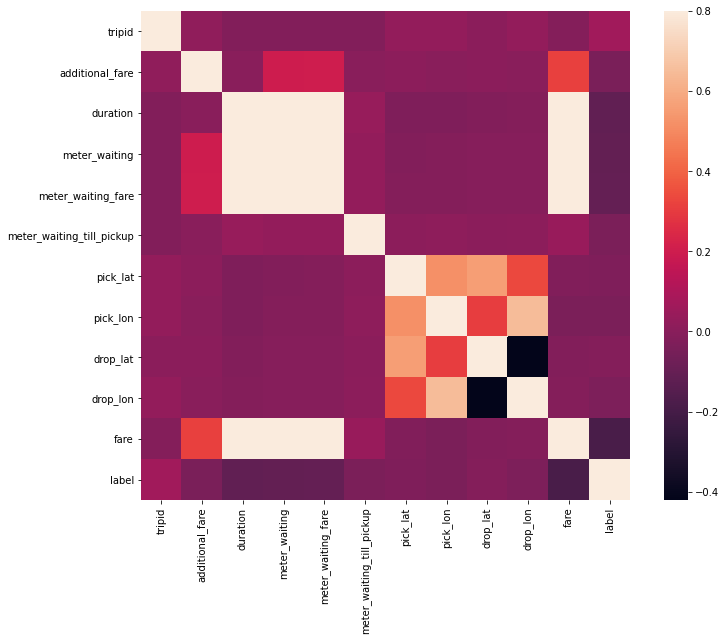

In [ ]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(data_frame.corr(), vmax=.8, square=True, fmt='.2f')

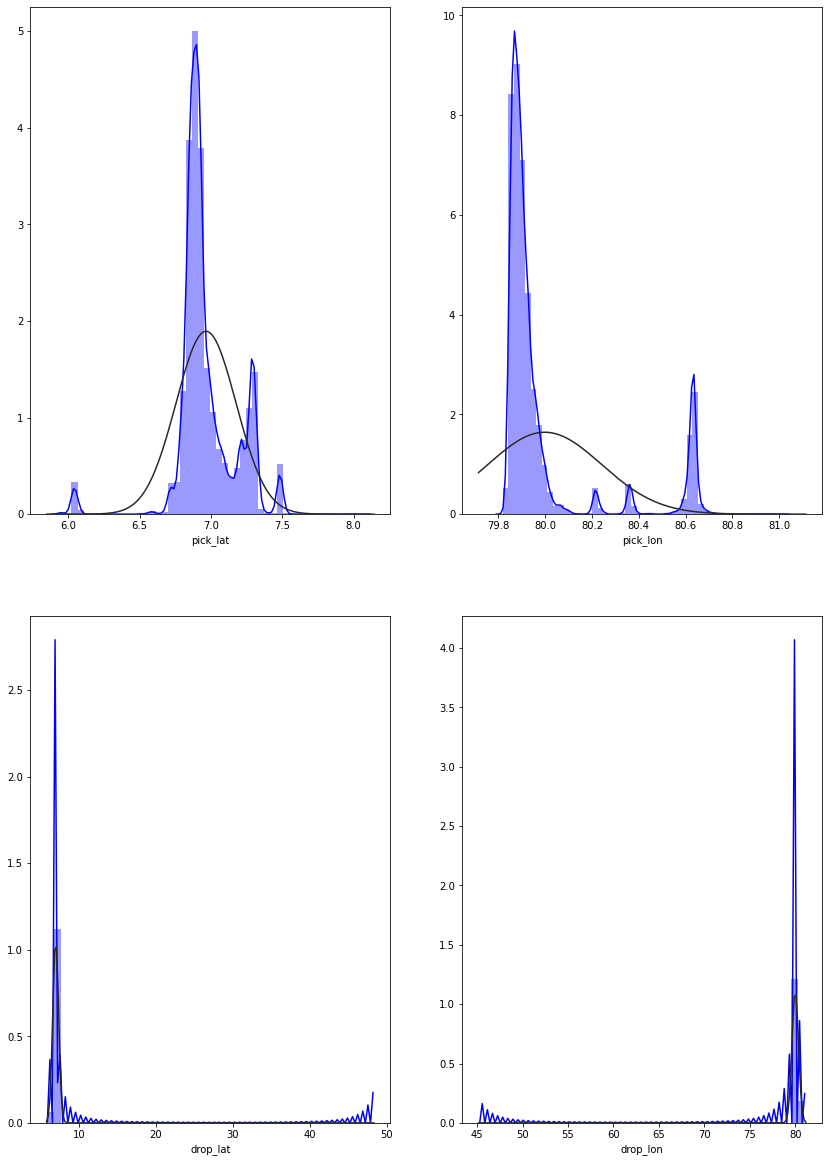

In [ ]:
#In this notebook, I'm going to divifr coordinates into bins
f, axes = plt.subplots(2,2, figsize=(10,20),)
plt.subplots_adjust(left=0.9, bottom=None, right=2, top=0.9, wspace=0.2, hspace=0.2)
sns.distplot(data_frame['pick_lat'], kde=True, color="b", ax=axes[0, 0],fit=norm)
sns.distplot(data_frame['pick_lon'], kde=True, color="b", ax=axes[0, 1],fit=norm)
sns.distplot(data_frame['drop_lat'], kde=True, color="b", ax=axes[1, 0],fit=norm)
sns.distplot(data_frame['drop_lon'], kde=True, color="b", ax=axes[1, 1],fit=norm)
plt.show()

In [ ]:
print("{0} max : {1}, min :  {2}".format('pick_lat',data_frame['pick_lat'].min(), data_frame['pick_lat'].max()))
print("{0} max : {1}, min :  {2}".format('pick_lon',data_frame['pick_lon'].min(), data_frame['pick_lon'].max()))
print("{0} max : {1}, min :  {2}".format('drop_lat',data_frame['drop_lat'].min(), data_frame['drop_lat'].max()))
print("{0} max : {1}, min :  {2}".format('drop_lon',data_frame['drop_lon'].min(), data_frame['drop_lon'].max()))

pick_lat max : 5.9376, min :  8.05101
pick_lon max : 79.8191, min :  81.0096
drop_lat max : 5.94186, min :  48.132
drop_lon max : 45.3077, min :  81.0097


In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

binDis = KBinsDiscretizer(n_bins=13)

binDis.fit(data_frame[['pick_lat','pick_lon','drop_lat','drop_lon']])

matrix = binDis.transform(data_frame[['pick_lat','pick_lon','drop_lat','drop_lon']])

In [ ]:
matrix.toarray()

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
#Try to drop NaN columns and train
temp_df = data_frame.dropna(subset=['additional_fare','duration','meter_waiting','meter_waiting_fare','meter_waiting_till_pickup','fare'])
temp_df = temp_df.drop(columns=['tripid','pickup_time','drop_time','pick_lat','pick_lon','drop_lat','drop_lon'])

In [ ]:
def encoding_label(label):
  if(label=='correct'):
    return 1
  else:
    return 0
X = temp_df.drop(columns=['label']).values
Y = temp_df['label'].apply(encoding_label).values


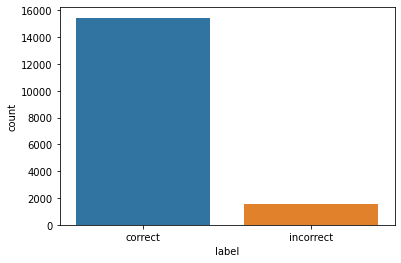

In [ ]:
#Plot the class labels
sns.countplot(x='label', data=temp_df)

In [ ]:
#Concat merge coordinate bins and rest of features
X_ = np.concatenate((X,matrix.toarray()),axis=1)

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

scaler = RobustScaler()
scaler.fit(X_)
X_ = scaler.transform(X_)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [ ]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X_, Y, test_size=0.20, random_state=1)

LR: 0.956097 (0.001649)
LDA: 0.953428 (0.001183)
KNN: 0.960210 (0.002261)
CART: 0.954702 (0.004436)
NB: 0.951353 (0.002616)


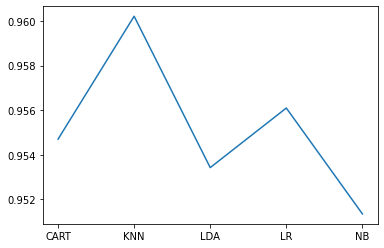

In [ ]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X_, Y, test_size=0.20, random_state=1)
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
 
def train_models(X_,Y):
	
	#models.append(('SVM', SVC(gamma=0.05, kernel='linear')))
	# evaluate each model in turn
	results = []
	names = []
	for name, model in models:
		kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
		cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='f1')
		results.append(cv_results)
		names.append(name)
		print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
	
	sns.lineplot(x=np.array(['LR','LDA','KNN','CART','NB']),y=[r.mean() for r in results])
	plt.show()
train_models(X_,Y)

 Number of bins #: 5
LR: 0.956210 (0.001899)
LDA: 0.953720 (0.001090)
KNN: 0.969875 (0.001257)
CART: 0.956366 (0.004757)
NB: 0.952090 (0.002097)


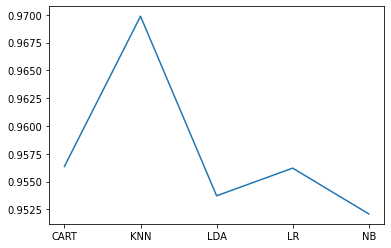

 Number of bins #: 6
LR: 0.956558 (0.001818)
LDA: 0.953254 (0.001455)
KNN: 0.969836 (0.001290)
CART: 0.956563 (0.004053)
NB: 0.952131 (0.002044)


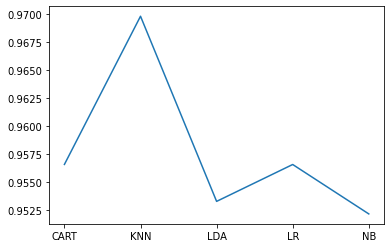

 Number of bins #: 7
LR: 0.956544 (0.001577)
LDA: 0.953805 (0.001157)
KNN: 0.969836 (0.001290)
CART: 0.955865 (0.004825)
NB: 0.952209 (0.002021)


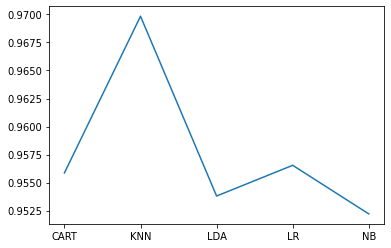

 Number of bins #: 8
LR: 0.956362 (0.001818)
LDA: 0.953672 (0.001191)
KNN: 0.969875 (0.001257)
CART: 0.954841 (0.005230)
NB: 0.952254 (0.001944)


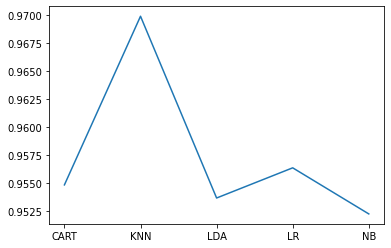

 Number of bins #: 9
LR: 0.955946 (0.001739)
LDA: 0.953524 (0.001231)
KNN: 0.969877 (0.001227)
CART: 0.955366 (0.004689)
NB: 0.952135 (0.001966)


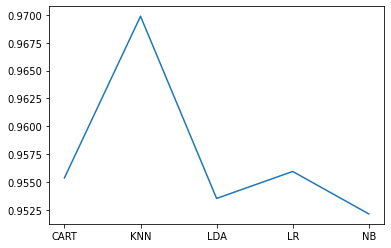

 Number of bins #: 10
LR: 0.956402 (0.001583)
LDA: 0.953594 (0.001207)
KNN: 0.969836 (0.001290)
CART: 0.955371 (0.004052)
NB: 0.952209 (0.002063)


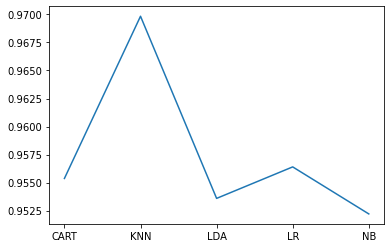

 Number of bins #: 11
LR: 0.957062 (0.003191)
LDA: 0.953679 (0.001010)
KNN: 0.969916 (0.001192)
CART: 0.953549 (0.003703)
NB: 0.952094 (0.002064)


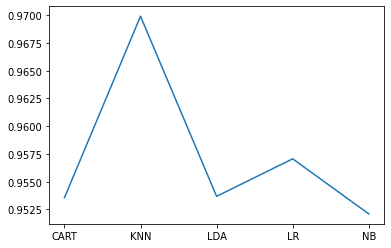

 Number of bins #: 12
LR: 0.956534 (0.001627)
LDA: 0.953401 (0.001468)
KNN: 0.969836 (0.001290)
CART: 0.955236 (0.005029)
NB: 0.952168 (0.001923)


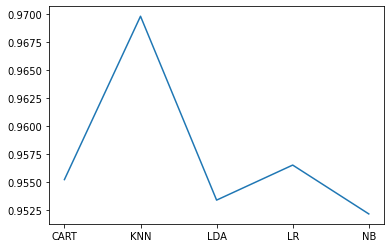

 Number of bins #: 13
LR: 0.957555 (0.002961)
LDA: 0.953428 (0.001183)
KNN: 0.969918 (0.001175)
CART: 0.954687 (0.003117)
NB: 0.952090 (0.001987)


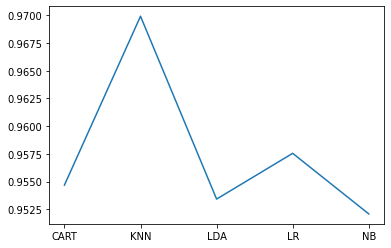

 Number of bins #: 14
LR: 0.956580 (0.002509)
LDA: 0.953723 (0.001136)
KNN: 0.969877 (0.001227)
CART: 0.954327 (0.003540)
NB: 0.952168 (0.002034)


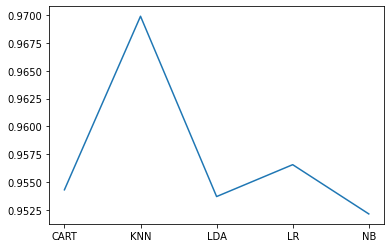

In [ ]:
#Try to train with different bins
n_bins = range(5,15)

for n in n_bins:
  binDis = KBinsDiscretizer(n_bins=n)

  binDis.fit(data_frame[['pick_lat','pick_lon','drop_lat','drop_lon']])

  matrix = binDis.transform(data_frame[['pick_lat','pick_lon','drop_lat','drop_lon']])

  #Concat merge coordinate bins and rest of features    
  X_ = np.concatenate((X,matrix.toarray()),axis=1)
  print(" Number of bins #: {0}".format(n))
  train_models(X_,Y)



In [ ]:
from sklearn.metrics import accuracy_score, f1_score
for model in models:
  model[1].fit(X_train, Y_train)
#for k in range(0,len(X_train)):
for model in models:
  print("Score accuracy {0}: {1}".format(model[0],f1_score(model[1].predict(X_validation), Y_validation)))

Score accuracy LR: 0.9560627231796306
Score accuracy LDA: 0.9536936657890662
Score accuracy KNN: 0.9602494154325798
Score accuracy CART: 0.9483766233766233
Score accuracy NB: 0.9544960397577263


In [ ]:
#Try to max voting bagging
from sklearn.metrics import accuracy_score, f1_score
for model in models:
  model[1].fit(X_train, Y_train)

Y_predictions = []
for k in range(0,len(X_validation)):
  data_point = X_validation[k]
  vote_1 = 0
  vote_0 = 0
  for model in models:
    prediction = model[1].predict([data_point])
    if(prediction[0]==1):
      vote_1 += 1
    else:
      vote_0 += 1
  #print(vote_1, vote_0)
  if(vote_1>vote_0):
    Y_predictions.append(1)
  else:
    Y_predictions.append(0)

print("Score accuracy {0}: {1}".format(model[0],f1_score(Y_predictions, Y_validation)))

Score accuracy NB: 0.956575682382134


In [ ]:
def bagging_manual(X_validation):
  Y_predictions = []
  for k in range(0,len(X_validation)):
    data_point = X_validation[k]
    vote_1 = 0
    vote_0 = 0
    for model in models:
      prediction = model[1].predict([data_point])
      if(prediction[0]==1):
        vote_1 += 1
      else:
        vote_0 += 1
    #print(vote_1, vote_0)
    if(vote_1>vote_0):
      Y_predictions.append(1)
    else:
      Y_predictions.append(0)
  return Y_predictions


In [ ]:
#Testing frame
test_frame = pd.read_csv("/content/gdrive/My Drive/ML Project Taxi Fair/test.csv")
trip_ids = test_frame['tripid']

matrix = binDis.transform(test_frame[['pick_lat','pick_lon','drop_lat','drop_lon']])

test_frame.drop(columns=['tripid','pickup_time','drop_time','pick_lat','pick_lon','drop_lat','drop_lon'], inplace=True)

X_test = test_frame.values

#Concat merge coordinate bins and rest of features
X_test_ = np.concatenate((X_test,matrix.toarray()),axis=1)

predicted = bagging_manual(X_test_)

data_dict = { 'trip_id':trip_ids, 'prediction':predicted}
pd_test_result = pd.DataFrame(data=data_dict)

#pd_test_result.to_csv('/content/gdrive/My Drive/ML Project Taxi Fair/sample_submission.csv')

In [ ]:
#The result is lower score than first one

In [ ]:
import graphviz 
from sklearn import tree
dot_data = tree.export_graphviz(models[3][1], out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris") 

'iris.pdf'